In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os
from typing import List, Tuple

import pandas as pd

import core.config as cconfig
import core.finance.portfolio_df_processing as cofinpdp
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import oms as oms
import reconciliation as reconcil

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-f1cb66c1-b737-4dd6-8e4b-4181edacd615.json'
INFO  # Git
  branch_name='AmpTask2534_Prod_reconciliation_01'
  hash='695a0a5f5'
  # Last commits:
    * 695a0a5f5 psmith   Checkpoint                                                        ( 7 minutes ago) Mon Sep 19 14:00:35 2022  (HEAD -> AmpTask2534_Prod_reconciliation_01, origin/AmpTask2534_Prod_reconciliation_01)
    *   1154b9150 psmith   Merge branch 'master' into AmpTask2534_Prod_reconciliation_01     (42 minutes ago) Mon Sep 19 13:26:03 2022           
    |\  
    | * 597b8ce02 GP Saggese AmpTask1786_Integrate_20220916 (#2568)                            (  22 hours ago) Sun Sep 18 15:40:56 2022  (origin/master, origin/HEAD, master)
# Machine info
  system=Linux
  node name=9fec6cd15180
  release=3.10.0-1160.53.1.el7.x86_64
  version=#1 SMP Fri Jan 14 13:59:45 UTC 2022
  machine=x86_64
  processor=x86_64
  cpu count=8
  

In [4]:
date = "2022-08-31"
start_timestamp = pd.Timestamp(date + " 10:15:00", tz="America/New_York")
_LOG.info("start_timestamp=%s", start_timestamp)
end_timestamp = pd.Timestamp(date + " 15:45:00", tz="America/New_York")
_LOG.info("end_timestamp=%s", start_timestamp)

INFO  start_timestamp=2022-08-31 10:15:00-04:00
INFO  end_timestamp=2022-08-31 10:15:00-04:00


In [5]:
!ls /data/cf_production/20220915/job.1002440809/job-sasm_job-jobid-1002440809/user_executable_run_0-1000005405809/cf_prod_system_log_dir/process_forecasts

In [ ]:
# /share/data/cf_production/20220919/job.1002450215/job-sasm_job-jobid-1002450215/user_executable_run_0-1000005484302/cf_prod_system_log_dir
# /share/data/cf_production/20220919/job.1002452903/user_executable_run_0-1000005489454/cf_prod_system_log_dir
prod_dir = (
    # "/share/data/cf_production/20220919/job.1002450215/job-sasm_job-jobid-1002450215/user_executable_run_0-1000005484302/cf_prod_system_log_dir"
    "/share/data/cf_production/20220919/job.1002452903/user_executable_run_0-1000005489454/cf_prod_system_log_dir"
)
prod_dir = prod_dir.replace("/share/data/", "/data/")
prod_portfolio_dir = os.path.join(prod_dir, "process_forecasts/portfolio")
prod_forecast_dir = os.path.join(prod_dir, "process_forecasts")
hdbg.dassert_dir_exists(prod_forecast_dir)

sim_dir = "/app/system_log_dir"
sim_portfolio_dir = os.path.join(sim_dir, "process_forecasts/portfolio")
sim_forecast_dir = os.path.join(sim_dir, "process_forecasts")
hdbg.dassert_dir_exists(sim_forecast_dir)

In [6]:
# hdbg.dassert_dir_exists(root_dir)
dict_ = {
    "prod_forecast_dir": prod_forecast_dir,
    "sim_forecast_dir": sim_forecast_dir,
    "prod_portfolio_dir": prod_portfolio_dir,
    "sim_portfolio_dir": sim_portfolio_dir,
    "freq": "15T",
    "start_timestamp": start_timestamp,
    "end_timestamp": end_timestamp,
}
#
config = cconfig.Config.from_dict(dict_)
display(config)

prod_forecast_dir: /data/tmp/AmpTask2534_Prod_reconciliation_20220901/system_log_dir.prod/process_forecasts
sim_forecast_dir: /data/tmp/AmpTask2534_Prod_reconciliation_20220901/system_log_dir.sim/process_forecasts
prod_portfolio_dir: /data/tmp/AmpTask2534_Prod_reconciliation_20220901/system_log_dir.prod/process_forecasts/portfolio
sim_portfolio_dir: /data/tmp/AmpTask2534_Prod_reconciliation_20220901/system_log_dir.sim/process_forecasts/portfolio
freq: 15T
start_timestamp: 2022-08-31 10:15:00-04:00
end_timestamp: 2022-08-31 15:45:00-04:00

# Forecasts

## Load prod and sim forecasts

In [7]:
prod_forecast_df = oms.ForecastProcessor.read_logged_target_positions(
    config["prod_forecast_dir"]
)
hpandas.df_to_str(prod_forecast_df, log_level=logging.INFO)

Loading `target_positions` files...:   0%|          | 0/25 [00:00<?, ?it/s]

curr_num_shares                                                                                                                   price                                                                                                                                                                                                                          position                                                                                                                                                                                                                                     prediction                                                                                                                                                                                     volatility                                                                                                                                                                                     spread                                                                                                             target_position                                                                                                                                                                                                                                      target_notional_trade                                                                                                                                                                                                                                          diff_num_shares                                                                                                                                                                                                 
asset_id                                   10365 11198 12007 12119 13412 13684 14527 14592 14881 15224 15740 15794 16224 16878 16897 17085 17109 17511 17933       10365       11198       12007       12119      13412       13684       14527       14592       14881      15224      15740       15794       16224       16878       16897       17085       17109       17511       17933        10365        11198       12007        12119       13412        13684        14527        14592       14881        15224        15740       15794       16224       16878        16897        17085        17109        17511        17933      10365     11198     12007     12119     13412     13684     14527     14592     14881     15224     15740     15794     16224     16878     16897     17085     17109     17511     17933      10365     11198     12007     12119     13412     13684     14527     14592     14881     15224     15740     15794     16224     16878     16897     17085     17109     17511     17933  10365 11198 12007 12119 13412 13684 14527 14592 14881 15224 15740 15794 16224 16878 16897 17085 17109 17511 17933           10365        11198        12007        12119        13412       13684        14527        14592       14881        15224        15740       15794       16224       16878        16897        17085        17109        17511        17933                 10365        11198        12007        12119        13412        13684        14527        14592        14881        15224        15740        15794        16224        16878        16897        17085        17109        17511       17933           10365     11198     12007     12119      13412     13684      14527      14592      14881      15224      15740      15794      16224      16878      16897      17085      17109      17511     17933
2022-08-31 09:45:17.668056-04:00            -7.0   4.0 -10.0  -2.0 -12.0  -5.0  14.0  -8.0 -21.0  11.0 -51.0 -23.0  -9.0 -12.0 -28.0 -11.0  -4.0 -10.0   1.0  329.571473  523.297333    290.8249  524.774773    94.1738  277.571867  163.036333  264.809333  157.204333   33.96386  46.173993   129.10938  165.216707  153.045473   140.17454  159.524427  201.972673  135.466667  114.

In [8]:
sim_forecast_df = oms.ForecastProcessor.read_logged_target_positions(
    config["sim_forecast_dir"]
)
hpandas.df_to_str(sim_forecast_df, log_level=logging.INFO)

Loading `target_positions` files...:   0%|          | 0/24 [00:00<?, ?it/s]

curr_num_shares                                                                                                                                                                                                  price                                                                                                                                                                                                                          position                                                                                                                                                                                                                                     prediction                                                                                                                                                                                     volatility                                                                                                                                                                                     spread                                                                                                             target_position                                                                                                                                                                                                                                     target_notional_trade                                                                                                                                                                                                                                     diff_num_shares                                                                                                                                                                                            
asset_id                            10365     11198     12007     12119      13412     13684      14527     14592     14881      15224      15740     15794     16224     16878      16897     17085     17109      17511      17933       10365       11198       12007       12119      13412       13684       14527       14592       14881      15224      15740       15794       16224       16878       16897       17085       17109       17511       17933        10365        11198        12007        12119       13412       13684        14527        14592       14881        15224        15740       15794       16224       16878        16897        17085        17109        17511        17933      10365     11198     12007     12119     13412     13684     14527     14592     14881     15224     15740     15794     16224     16878     16897     17085     17109     17511     17933      10365     11198     12007     12119     13412     13684     14527     14592     14881     15224     15740     15794     16224     16878     16897     17085     17109     17511     17933  10365 11198 12007 12119 13412 13684 14527 14592 14881 15224 15740 15794 16224 16878 16897 17085 17109 17511 17933           10365        11198        12007        12119       13412       13684        14527        14592       14881        15224        15740        15794       16224       16878        16897       17085        17109        17511        17933                 10365        11198        12007        12119        13412       13684        14527        14592        14881        15224        15740       15794       16224       16878        16897       17085        17109        17511       17933           10365     11198     12007     12119      13412     13684      14527      14592     14881      15224      15740     15794     16224     16878      16897     17085      17109      17511     17933
2022-08-31 10:00:02-04:00             0.0       0.0       0.0       0.0        0.0       0.0        0.0       0.0       0.0        0.0        0.0       0.0       0.0       0.0        0.0       0.0       0.0        0.0        0.0    330.2125  525.

## Compute forecast prod delay

In [9]:
prod_forecast_delay = reconcil.compute_delay(prod_forecast_df, config["freq"])
hpandas.df_to_str(prod_forecast_delay, log_level=logging.INFO)

,delay
2022-08-31 09:45:00-04:00,0 days 00:00:17.668056
2022-08-31 10:00:00-04:00,0 days 00:00:17.469223
2022-08-31 10:15:00-04:00,0 days 00:00:17.826773
,...
2022-08-31 15:15:00-04:00,0 days 00:00:30.235741
2022-08-31 15:30:00-04:00,0 days 00:00:31.567356
2022-08-31 15:45:00-04:00,0 days 00:00:31.088384


<AxesSubplot:xlabel='wall_clock_timestamp'>

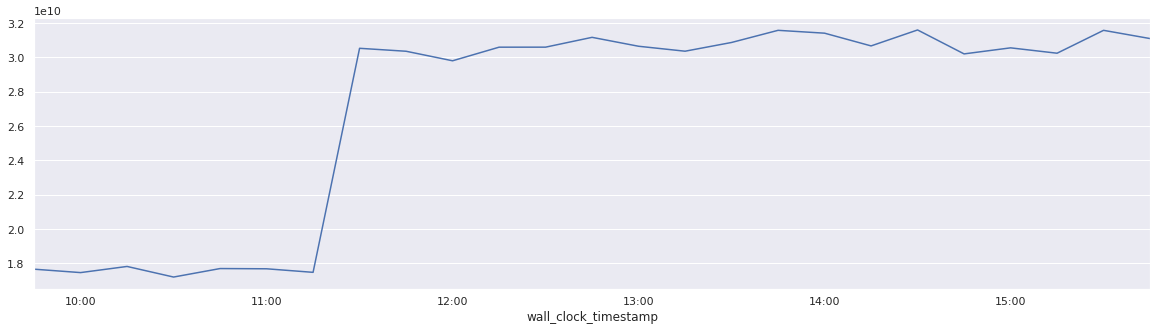

In [10]:
prod_forecast_delay.plot()

In [11]:
prod_forecast_df.index = prod_forecast_df.index.round(config["freq"])
sim_forecast_df.index = sim_forecast_df.index.round(config["freq"])
prod_forecast_df = prod_forecast_df.loc[start_timestamp:end_timestamp]
sim_forecast_df = sim_forecast_df.loc[start_timestamp:end_timestamp]

## Compare forecast dataframes

In [12]:
forecast_corrs = dtfmod.compute_correlations(prod_forecast_df, sim_forecast_df)
hpandas.df_to_str(forecast_corrs, precision=3, log_level=logging.INFO)

,curr_num_shares,price,position,prediction,volatility,spread,target_position,target_notional_trade,diff_num_shares
10365,0.81,0.97,0.81,0.979,0.987,NaN,0.818,0.678,0.679
11198,0.919,0.948,0.919,0.981,0.992,NaN,0.963,0.891,0.891
12007,0.845,0.963,0.846,0.976,0.989,NaN,0.852,0.748,0.748
,...,...,...,...,...,...,...,...,...
17109,0.931,0.982,0.932,0.968,0.972,NaN,0.923,0.915,0.914
17511,0.906,0.955,0.907,0.99,0.99,NaN,0.911,0.883,0.883
17933,0.8,0.958,0.8,0.951,0.966,NaN,0.814,0.747,0.746


In [13]:
sort_col = "prediction"
hpandas.df_to_str(
    forecast_corrs.sort_values(sort_col, ascending=False),
    num_rows=10,
    precision=3,
    log_level=logging.INFO,
)

,curr_num_shares,price,position,prediction,volatility,spread,target_position,target_notional_trade,diff_num_shares
16897,0.925,0.985,0.924,0.992,0.995,NaN,0.92,0.936,0.936
15794,0.901,0.97,0.901,0.991,0.986,NaN,0.942,0.87,0.87
17511,0.906,0.955,0.907,0.99,0.99,NaN,0.911,0.883,0.883
12119,0.97,0.927,0.97,0.988,0.991,NaN,0.981,0.988,0.988
15740,0.858,0.993,0.858,0.986,0.982,NaN,0.876,0.76,0.759
,...,...,...,...,...,...,...,...,...
13412,0.901,0.985,0.901,0.958,0.988,NaN,0.903,0.898,0.898
13684,0.706,0.933,0.706,0.956,0.981,NaN,0.816,0.802,0.802
17933,0.8,0.958,0.8,0.951,0.966,NaN,0.814,0.747,0.746
16224,0.725,0.978,0.724,0.948,0.996,NaN,0.764,0.753,0.755


# Orders

## Load prod and sim orders

In [14]:
prod_order_df = oms.ForecastProcessor.read_logged_orders(
    config["prod_forecast_dir"]
)
hpandas.df_to_str(prod_order_df, log_level=logging.INFO)

Loading `orders` files...:   0%|          | 0/25 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz
0,2022-08-31 09:45:23.614500-04:00,10365,price@twap,2022-08-31 09:45:23.614500-04:00,2022-08-31 10:00:23.614500-04:00,-7.0,3.426931,America/New_York
1,2022-08-31 09:45:23.614500-04:00,11198,price@twap,2022-08-31 09:45:23.614500-04:00,2022-08-31 10:00:23.614500-04:00,4.0,-5.317124,America/New_York
2,2022-08-31 09:45:23.614500-04:00,12007,price@twap,2022-08-31 09:45:23.614500-04:00,2022-08-31 10:00:23.614500-04:00,-10.0,12.82068,America/New_York
,...,...,...,...,...,...,...,...
465,2022-08-31 15:45:31.514382-04:00,17109,price@twap,2022-08-31 15:45:31.514382-04:00,2022-08-31 16:00:31.514382-04:00,-4.0,8.593991,America/New_York
466,2022-08-31 15:45:31.514382-04:00,17511,price@twap,2022-08-31 15:45:31.514382-04:00,2022-08-31 16:00:31.514382-04:00,1.0,10.241609,America/New_York
467,2022-08-31 15:45:31.514382-04:00,17933,price@twap,2022-08-31 15:45:31.514382-04:00,2022-08-31 16:00:31.514382-04:00,11.0,-2.967905,America/New_York


In [15]:
sim_order_df = oms.ForecastProcessor.read_logged_orders(
    config["sim_forecast_dir"]
)
hpandas.df_to_str(sim_order_df, log_level=logging.INFO)

Loading `orders` files...:   0%|          | 0/24 [00:00<?, ?it/s]

/venv/lib/python3.8/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz
0,2022-08-31 10:00:02-04:00,10365,price@twap,2022-08-31 10:00:02-04:00,2022-08-31 10:15:02-04:00,0.0,-10.290801,America/New_York
1,2022-08-31 10:00:02-04:00,11198,price@twap,2022-08-31 10:00:02-04:00,2022-08-31 10:15:02-04:00,0.0,-2.097243,America/New_York
2,2022-08-31 10:00:02-04:00,12007,price@twap,2022-08-31 10:00:02-04:00,2022-08-31 10:15:02-04:00,0.0,5.116183,America/New_York
,...,...,...,...,...,...,...,...
451,2022-08-31 15:45:02-04:00,17109,price@twap,2022-08-31 15:45:02-04:00,2022-08-31 16:00:02-04:00,-5.676893,9.568405,America/New_York
452,2022-08-31 15:45:02-04:00,17511,price@twap,2022-08-31 15:45:02-04:00,2022-08-31 16:00:02-04:00,10.280641,-0.752702,America/New_York
453,2022-08-31 15:45:02-04:00,17933,price@twap,2022-08-31 15:45:02-04:00,2022-08-31 16:00:02-04:00,11.147231,-4.34382,America/New_York


# Portfolios

## Load prod portfolio

In [16]:
prod_portfolio_df, prod_portfolio_stats_df = reconcil.load_portfolio_artifacts(
    config["prod_portfolio_dir"],
    config["start_timestamp"],
    config["end_timestamp"],
    config["freq"],
    normalize_bar_times=False,
)

Loading `holdings` files...:   0%|          | 0/25 [00:00<?, ?it/s]

Loading `holdings_marked_to_market` files...:   0%|          | 0/25 [00:00<?, ?it/s]

Loading `flows` files...:   0%|          | 0/25 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/25 [00:00<?, ?it/s]

In [17]:
hpandas.df_to_str(prod_portfolio_df, log_level=logging.INFO)

holdings                                                                                                                                            holdings_marked_to_market                                                                                                                                                                                                                                                       flows                                                                                                                                                                                                                                               pnl                                                                                                                                                                                     
                                    10365  11198  12007  12119  13412  13684  14527  14592  14881  15224  15740  15794  16224  16878  16897  17085  17109  17511  17933       -1                         10365        11198       12007        12119       13412       13684        14527        14592       14881        15224        15740       15794       16224       16878        16897        17085        17109        17511        17933       -1           10365        11198        12007        12119        13412       13684        14527        14592        14881        15224        15740        15794        16224       16878        16897        17085        17109        17511        17933     10365     11198     12007     12119     13412     13684      14527     14592     14881     15224     15740     15794     16224     16878     16897     17085     17109     17511     17933
2022-08-31 10:15:17.826773-04:00     -5.0   -2.0    2.0    2.0    5.0    0.0  -17.0    3.0   -2.0   20.0   27.0    0.0    0.0   -3.0  -10.0   10.0   -5.0  -16.0   -8.0  5229.968945              -1643.346562 -1049.595625  579.271213  1045.780962  472.888312         0.0 -2764.143369   795.592819 -314.706825    684.78075  1237.397512         0.0         0.0 -459.682613 -1402.421875  1598.590062 -1008.250844   -2166.7649    -914.9925  5229.968945  328.620114     524.9129  -289.274768 -3662.392895   188.963336        -0.0  -650.100614   530.248186   472.433443  -308.075593   458.434205  -646.484712         -0.0        -0.0         -0.0 -1757.918242   201.714475  3656.690084    457.42369  6.677051   1.12415 -1.617236  3.766037 -0.202533       0.0  14.544142 -5.743589  0.092949 -0.233837 -11.09067  3.884726       0.0  3.296437  1.318375  0.937652  3.458581 -4.300928   1.52664
2022-08-31 10:30:17.210167-04:00     -4.0    1.0    2.0   -5.0    3.0   -1.0  -10.0   -4.0    1.0  -13.0   27.0    2.0    0.0   -3.0  -10.0    5.0    7.0   19.0   -4.0  1757.919629               -1309.99625    523.50625    577.5824 -2609.086167    285.0972 -277.201169   -1621.4925   -1056.9725  158.296562  -444.932719  1235.562862   257.47505         0.0 -457.455581 -1400.159375   797.671656   1408.34155  2567.476413  -457.819275  1757.919629 -327.525053 -1570.689505         -0.0  3652.559417   190.252863  276.888607 -1135.248614  1849.793583  -475.573894  1129.272102         -0.0  -256.628377         -0.0        -0.0         -0.0   797.256143 -2413.931018 -4730.770104  -457.705466   5.82526   2.41237 -1.688813 -2.307712   2.46175 -0.312562   7.402255 -2.771736 -2.570506 -0.441367  -1.83465  0.846673       0.0  2.227031    2.2625 -3.662263  2.661375  3.471208 -0.532241
2022-08-31 10:45:17.704254-04:00     -3.0    1.0    3.0    2.0   -1.0    0.0   -9.0   -5.0    1.0  -36.0   -8.0    2.0    0.0   -3.0   16.0    6.0   10.0   10.0  -18.0 -1510.453749                -981.84375    523.94375  867.337256  1044.385963  -95.215375         0.0 -1461.698944 -1319.494906  158.337769 -1230.674175    -366.5326  256.497113         0.0 -454.015331    2245.9736     955.1865   2012.30675  1353.612312 -2057.509913 -1510.453749 -326.864676         -0.0  -288.724052 -3655.175378   380.8

In [18]:
hpandas.df_to_str(prod_portfolio_stats_df, log_level=logging.INFO)

,pnl,gross_volume,net_volume,gmv,nmv,cash,net_wealth,leverage
2022-08-31 10:15:17.826773-04:00,17.437947,14133.687256,494.80639,18138.206744,-5309.603481,5229.968945,-79.634536,-227.768097
2022-08-31 10:30:17.210167-04:00,13.448574,19264.094745,3472.049316,17446.125479,-1824.105592,1757.919629,-66.185962,-263.592533
2022-08-31 10:45:17.704254-04:00,6.328232,14974.890909,3268.373378,17384.566006,1450.596019,-1510.453749,-59.85773,-290.431427
,...,...,...,...,...,...,...,...
2022-08-31 15:00:30.548124-04:00,0.575153,18063.085512,-6258.809934,18154.379363,-4699.61425,4641.927747,-57.686503,-314.707571
2022-08-31 15:15:30.235741-04:00,-3.837113,16191.721321,4371.194488,18884.392775,-332.256875,270.733259,-61.523616,-306.945428
2022-08-31 15:30:31.567356-04:00,12.962694,14728.362877,-1539.300382,18265.530925,-1858.594562,1810.03364,-48.560922,-376.13641


## Load sim portfolio

In [19]:
sim_portfolio_df, sim_portfolio_stats_df = reconcil.load_portfolio_artifacts(
    config["sim_portfolio_dir"],
    config["start_timestamp"],
    config["end_timestamp"],
    config["freq"],
    normalize_bar_times=False,
)

Loading `holdings` files...:   0%|          | 0/24 [00:00<?, ?it/s]

Loading `holdings_marked_to_market` files...:   0%|          | 0/24 [00:00<?, ?it/s]

Loading `flows` files...:   0%|          | 0/24 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/24 [00:00<?, ?it/s]

In [20]:
hpandas.df_to_str(sim_portfolio_df, log_level=logging.INFO)

holdings                                                                                                                                                                                                            holdings_marked_to_market                                                                                                                                                                                                                                                             flows                                                                                                                                                                                                                                             pnl                                                                                                                                                                                    
                               10365     11198     12007     12119     13412     13684      14527     14592     14881      15224      15740     15794     16224     16878      16897     17085      17109      17511      17933          -1                         10365        11198        12007        12119       13412       13684        14527        14592       14881        15224        15740        15794       16224       16878        16897        17085        17109        17511        17933          -1            10365        11198        12007        12119        13412       13684        14527        14592        14881        15224        15740       15794        16224        16897        17085        17109        17511       17933       16878     10365     11198     12007     12119     13412     13684     14527     14592     14881     15224     15740     15794     16224     16878     16897     17085     17109     17511     17933
2022-08-31 10:15:02-04:00 -10.290801 -2.097243  5.116183  1.301862  4.221964  0.844882 -12.032555  2.605239 -2.510429  23.505313  16.222854  2.610574 -2.820981       0.0 -10.170247  9.531708  -5.339371  -16.92166   -8.22991  1006138.584919              -3378.082508 -1099.248696  1480.567945   680.475551  399.688029   235.07404 -1953.445244   690.304214 -395.390127   804.569223   742.386742   337.400742 -467.876098         0.0 -1424.605818  1523.828365 -1075.522897 -2288.908018  -941.913208  1006138.584919  3381.512089  1100.539899 -1481.585213   -680.70079  -399.356281 -235.021809  1956.113824   -690.80211   395.051152  -804.688082  -743.398886 -337.854233   467.193007   1426.12966 -1523.557093  1076.535669  2291.265939  941.208179         NaN  3.429581  1.291202 -1.017268 -0.225239  0.331748  0.052231   2.66858 -0.497896 -0.338975 -0.118859 -1.012144 -0.453491 -0.683091       NaN  1.523842  0.271272  1.012772   2.35792 -0.705029
2022-08-31 10:30:02-04:00   4.696999  2.723868 -3.590989 -6.118488  2.365603 -1.612564   -9.68102 -9.616843  1.912013 -16.853525   18.60434   4.13219 -2.441787 -1.636811        0.0  5.281137    7.18986  16.764461  -4.551899  1001119.894347               1538.701524  1426.089986 -1037.607335 -3190.693911  225.159411 -446.638063 -1569.099656  -2540.69778  303.281969   -576.59955   852.047757   531.020212 -407.070623 -249.338276          0.0   841.477912  1446.678812  2268.063909  -520.608353  1001119.894347 -4908.199786 -2524.095444   2514.32611  3871.677806   176.454338   681.00014  -381.299634  3229.237126   -700.27315  1381.185714  -109.003833 -195.847383   -63.088976 -1424.092221   677.999866  -2520.58598 -4552.668863 -420.915778  249.499376  8.584245  1.243239 -3.849171  0.508344   1.92572 -0.711963  3.045955 -1.764868 -1.601055  0.016941  0.657182 -2.227913   -2.2835    0.1611  0.513597 -4.350587  1.615728  4.303064  0.389077
2022-08-31 10:45:02-04:00  -3.295039  2.241157  4.787237       0.0 -2.176919 -2.588847  -11.08637 -5.577665  1.232132 -49.812611 -12.033435  8.101508 -0.773144  2.282585  16.139768  5.984327  10.399826  10.547672 -12.815444   998255.176659             

In [21]:
hpandas.df_to_str(sim_portfolio_stats_df, log_level=logging.INFO)

,pnl,gross_volume,net_volume,gmv,nmv,cash,net_wealth,leverage
2022-08-31 10:15:02-04:00,7.887157,19932.513915,-6138.584919,19919.287465,-6130.697762,1006138.584919,1000007.887157,0.019919
2022-08-31 10:30:02-04:00,6.175134,30581.451523,5018.690572,19970.875037,-1105.832056,1001119.894347,1000014.062291,0.019971
2022-08-31 10:45:02-04:00,-7.524915,19310.424413,2864.717687,19995.680514,1751.360717,998255.176659,1000006.537376,0.019996
,...,...,...,...,...,...,...,...
2022-08-31 15:00:02-04:00,0.23347,21526.251743,-6247.003265,20004.715242,-4452.676481,1004486.861504,1000034.185023,0.020004
2022-08-31 15:15:02-04:00,1.953061,19883.6548,3196.996774,20056.375132,-1253.726646,1001289.86473,1000036.138084,0.020056
2022-08-31 15:30:02-04:00,4.925467,18962.302178,1333.626517,19985.254682,84.825339,999956.238213,1000041.063552,0.019984


## Compute prod portfolio delay

In [22]:
prod_portfolio_delay = reconcil.compute_delay(prod_portfolio_df, config["freq"])

In [23]:
hpandas.df_to_str(prod_portfolio_delay, log_level=logging.INFO)

,delay
2022-08-31 10:15:00-04:00,0 days 00:00:17.826773
2022-08-31 10:30:00-04:00,0 days 00:00:17.210167
2022-08-31 10:45:00-04:00,0 days 00:00:17.704254
,...
2022-08-31 15:00:00-04:00,0 days 00:00:30.548124
2022-08-31 15:15:00-04:00,0 days 00:00:30.235741
2022-08-31 15:30:00-04:00,0 days 00:00:31.567356


<AxesSubplot:>

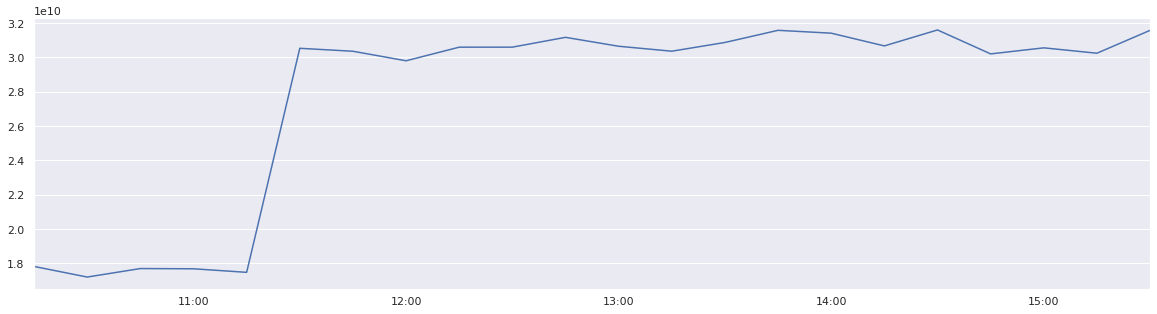

In [24]:
prod_portfolio_delay.plot()

In [25]:
_LOG.info("prod portfolio delay mean=%s", prod_portfolio_delay.mean())
_LOG.info("prod portfolio delay std=%s", prod_portfolio_delay.std())

INFO  prod portfolio delay mean=0 days 00:00:27.751888727
INFO  prod portfolio delay std=0 days 00:00:05.664955167


## Normalize bar times

In [26]:
dfs = [
    prod_portfolio_df,
    prod_portfolio_stats_df,
    sim_portfolio_df,
    sim_portfolio_stats_df,
]

In [27]:
for df in dfs:
    df.index = df.index.round(config["freq"])

## Compare portfolio stats

In [28]:
portfolio_stats_dfs = {
    "prod": prod_portfolio_stats_df,
    "sim": sim_portfolio_stats_df,
}
portfolio_stats_dfs = pd.concat(portfolio_stats_dfs, axis=1)

In [29]:
hpandas.df_to_str(portfolio_stats_dfs, log_level=logging.INFO)

prod                                                                                                 sim                                                                                                
                                 pnl  gross_volume   net_volume           gmv          nmv         cash net_wealth    leverage       pnl  gross_volume   net_volume           gmv          nmv            cash      net_wealth  leverage
2022-08-31 10:15:00-04:00  17.437947  14133.687256    494.80639  18138.206744 -5309.603481  5229.968945 -79.634536 -227.768097  7.887157  19932.513915 -6138.584919  19919.287465 -6130.697762  1006138.584919  1000007.887157  0.019919
2022-08-31 10:30:00-04:00  13.448574  19264.094745  3472.049316  17446.125479 -1824.105592  1757.919629 -66.185962 -263.592533  6.175134  30581.451523  5018.690572  19970.875037 -1105.832056  1001119.894347  1000014.062291  0.019971
2022-08-31 10:45:00-04:00   6.328232  14974.890909  3268.373378  17384.566006  1450.596019 -1510.453749  -59.85773 -290.431427 -7.524915  19310.424413  2864.717687  19995.680514  1751.360717   998255.176659  1000006.537376  0.019996
                                 ...           ...          ...           ...          ...          ...        ...         ...       ...           ...          ...           ...          ...             ...             ...       ...
2022-08-31 15:00:00-04:00   0.575153  18063.085512 -6258.809934  18154.379363  -4699.61425  4641.927747 -57.686503 -314.707571   0.23347  21526.251743 -6247.003265  20004.715242 -4452.676481  1004486.861504  1000034.185023  0.020004
2022-08-31 15:15:00-04:00  -3.837113  16191.721321  4371.194488  18884.392775  -332.256875   270.733259 -61.523616 -306.945428  1.953061    19883.6548  3196.996774  20056.375132 -1253.726646   1001289.86473  1000036.138084  0.020056
2022-08-31 15:30:00-04:00  12.962694  14728.362877 -1539.300382  18265.530925 -1858.594562   1810.03364 -48.560922  -376.13641  4.925467  18962.302178  1333.626517  19985.254682    84.825339   999956.238213  1000041.063552  0.019984

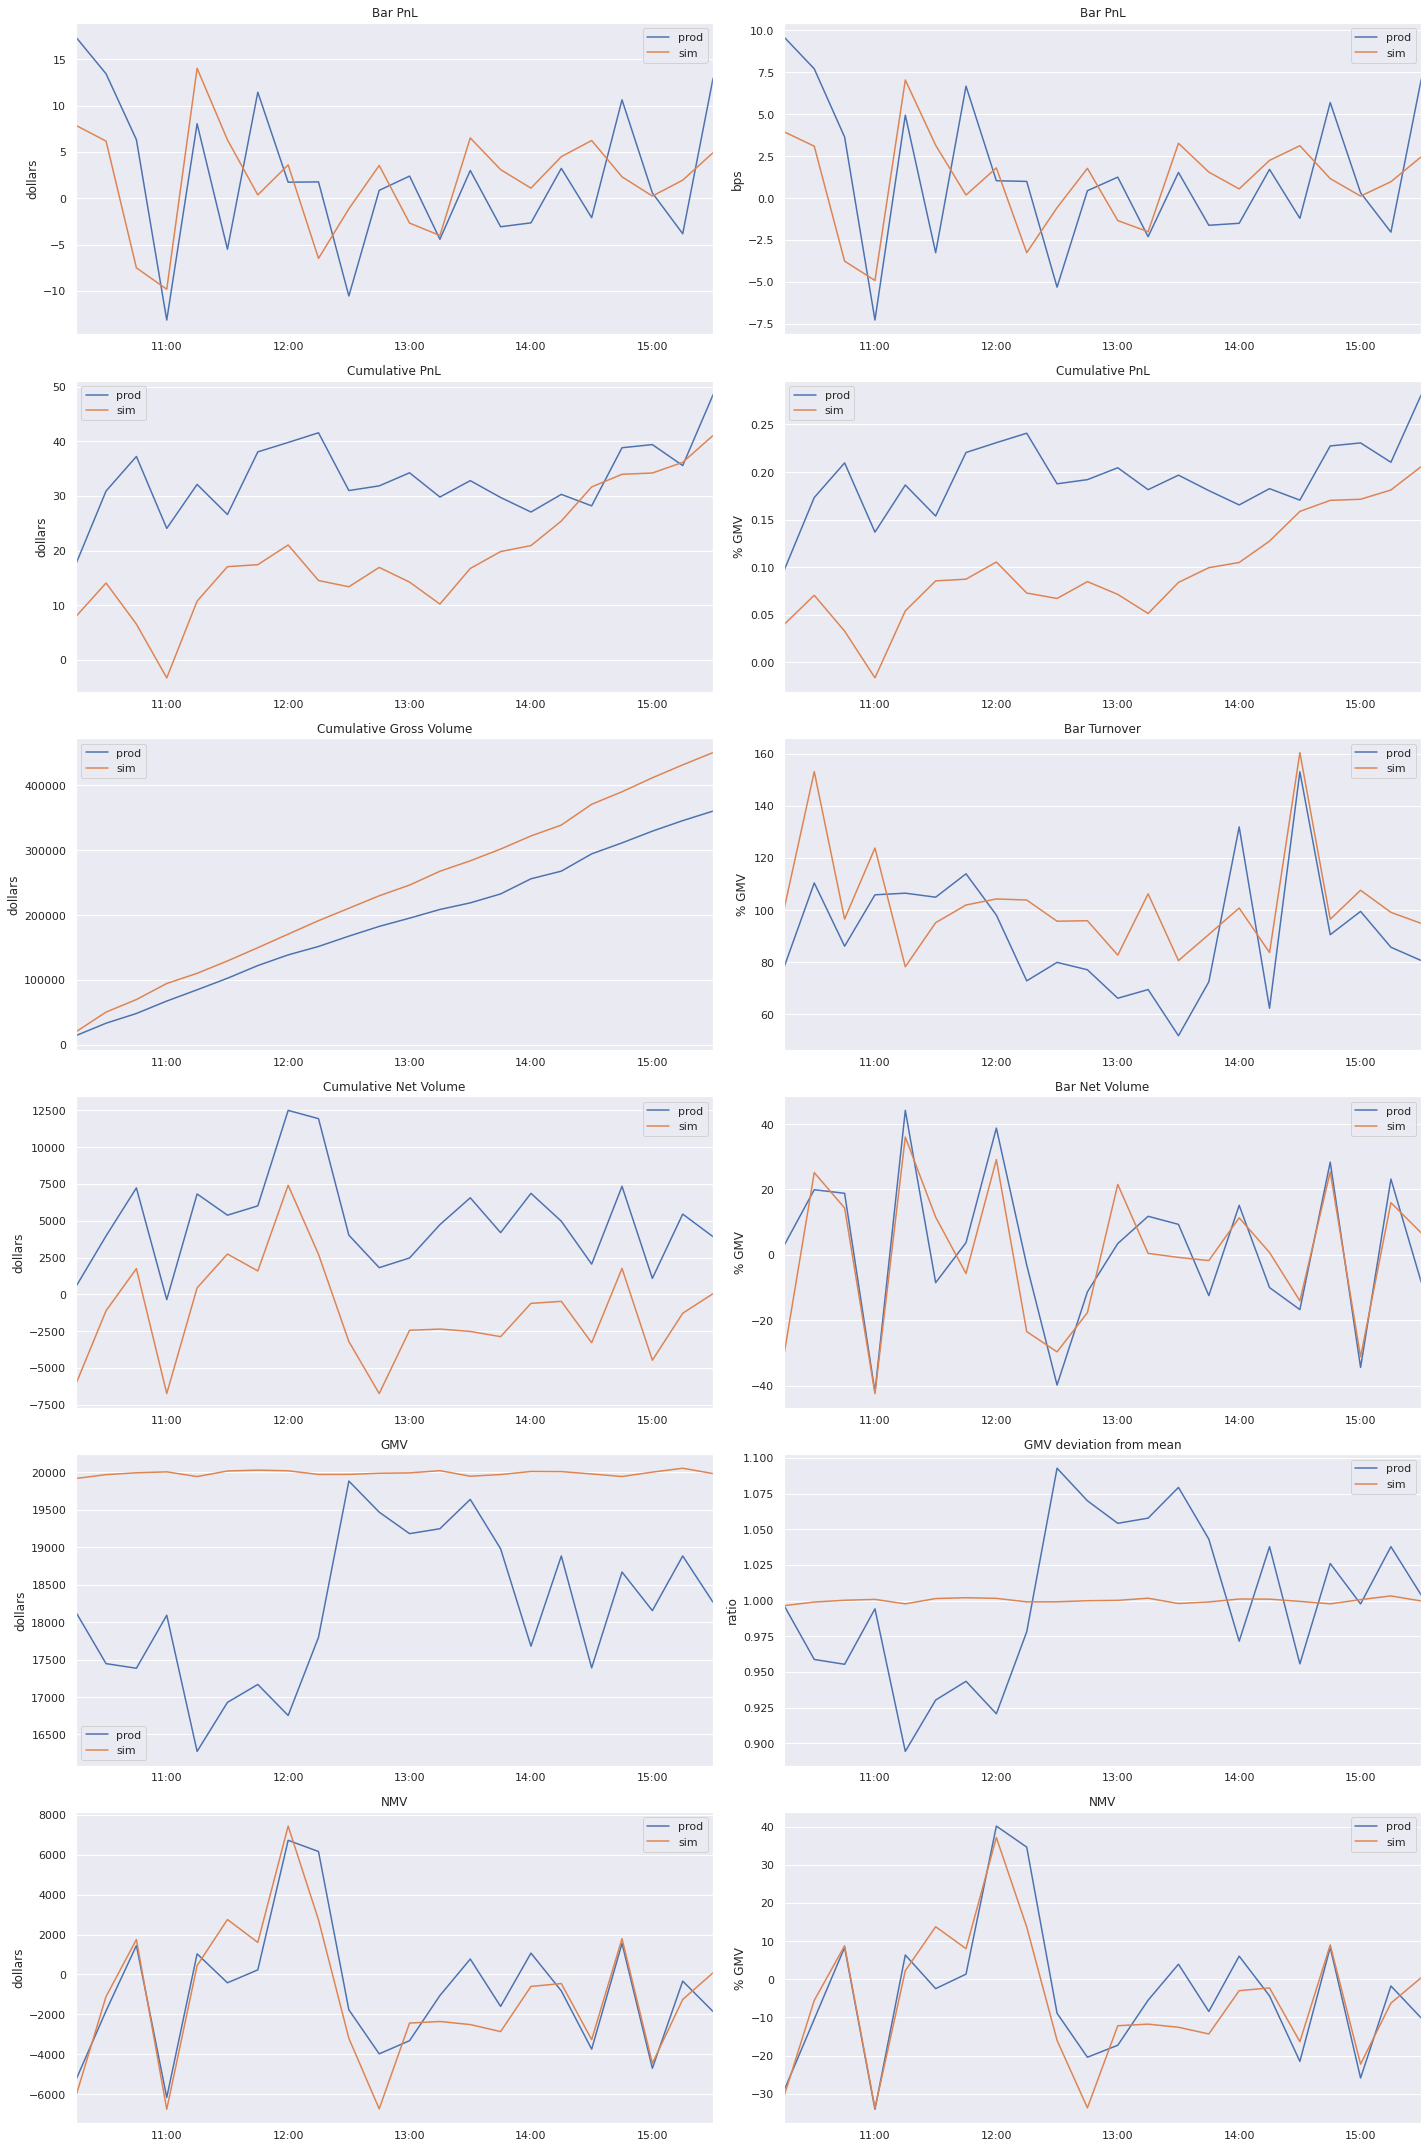

In [30]:
coplotti.plot_portfolio_stats(portfolio_stats_dfs)

In [31]:
portfolio_stats_corrs = dtfmod.compute_correlations(
    prod_portfolio_stats_df, sim_portfolio_stats_df
)
display(portfolio_stats_corrs.round(3))

,correlation
pnl,0.440
gross_volume,0.690
net_volume,0.838
gmv,-0.068
nmv,0.882
cash,0.882
net_wealth,0.543
leverage,-0.100


In [32]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_dfs, config["freq"]
)
display(stats_sxs)

prod       sim
ratios     sharpe_ratio                    52.50     62.68
           sharpe_ratio_standard_error     41.65     41.98
           sr.tval                          1.32      1.57
           sr.pval                          0.20      0.13
           kratio                          17.76     62.39
dollar     gmv_mean                     18196.22  19990.22
           gmv_stdev                     1004.39     32.90
           annualized_mean_return       77292.42  65425.67
           annualized_volatility         1472.11   1043.74
           max_drawdown                    14.50     17.36
           pnl_mean                         2.21      1.87
           pnl_std                          7.86      5.57
           turnover_mean                16367.92  20464.06
           turnover_stdev                3766.49   4059.64
           market_bias_mean              -813.33  -1159.57
           market_bias_stdev             3234.55   3440.27
percentage annualized_mean_return         448.10    327.89
           annualized_volatility            8.15      5.23
           max_drawdown                     0.08      0.09
           pnl_mean                         0.01      0.01
           pnl_std                          0.04      0.03
           turnover_mean                   90.79    102.37
           turnover_stdev                  23.87     20.31
           market_bias_mean                -4.15     -5.81
           market_bias_stdev               18.20     17.21

## Compare portfolios at the instrument level

In [33]:
portfolio_corrs = dtfmod.compute_correlations(prod_portfolio_df, sim_portfolio_df)
hpandas.df_to_str(portfolio_corrs, precision=3, log_level=logging.INFO)

,holdings,holdings_marked_to_market,flows,pnl
10365,0.803,0.803,0.605,0.767
11198,0.923,0.923,0.896,0.591
12007,0.834,0.834,0.711,0.725
,...,...,...,...
17511,0.912,0.912,0.887,0.457
17933,0.786,0.786,0.746,0.755
-1,0.882,0.882,NaN,NaN


In [34]:
sort_col = "pnl"
hpandas.df_to_str(
    portfolio_corrs.sort_values(sort_col, ascending=False),
    num_rows=10,
    precision=3,
    log_level=logging.INFO,
)

,holdings,holdings_marked_to_market,flows,pnl
17085,0.77,0.772,0.627,0.815
17109,0.93,0.931,0.899,0.792
10365,0.803,0.803,0.605,0.767
17933,0.786,0.786,0.746,0.755
16897,0.923,0.922,0.927,0.744
,...,...,...,...
15740,0.807,0.807,0.727,0.413
16224,0.727,0.725,0.761,0.379
15794,0.902,0.902,0.883,0.269
16878,0.395,0.397,-0.249,0.174


In [ ]:
# OMS

In [ ]:
shares_df = cofinpdp.compute_shares_traded(
    prod_portfolio_df, prod_order_df, "15T"
)

In [ ]:
shares_df.columns.levels[0]

In [ ]:
# shares_df["estimated_price_per_share"]
# shares_df["underfill"] / shares_df["order_share_target_as_int"]
shares_df["order_share_target_as_int"]

# System configs

In [35]:
# TODO(Paul): Clean up the system config handling.
def load_config_as_list(path):
    with open(path) as f:
        lines = f.readlines()
    _LOG.debug("Lines read=%d", len(lines))
    return lines

In [36]:
def diff_lines(list1, list2) -> Tuple[List[str], List[str]]:
    list1_only = list(set(list1) - set(list2))
    list2_only = list(set(list2) - set(list1))
    return list1_only, list2_only

In [37]:
prod_system_config_output = load_config_as_list(
    prod_dir + "/system_config.output.txt"
)
sim_system_config_output = load_config_as_list(
    sim_dir + "/system_config.output.txt"
)
prod_system_config_input = load_config_as_list(
    prod_dir + "/system_config.input.txt"
)
sim_system_config_input = load_config_as_list(
    sim_dir + "/system_config.input.txt"
)

In [38]:
prod_output_only, sim_output_only = diff_lines(
    prod_system_config_output, sim_system_config_output
)

In [39]:
# prod_output_only

In [40]:
# sim_output_only